DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators with features [0, 1] has a score of 0.8666666666666667
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.9933333333333333


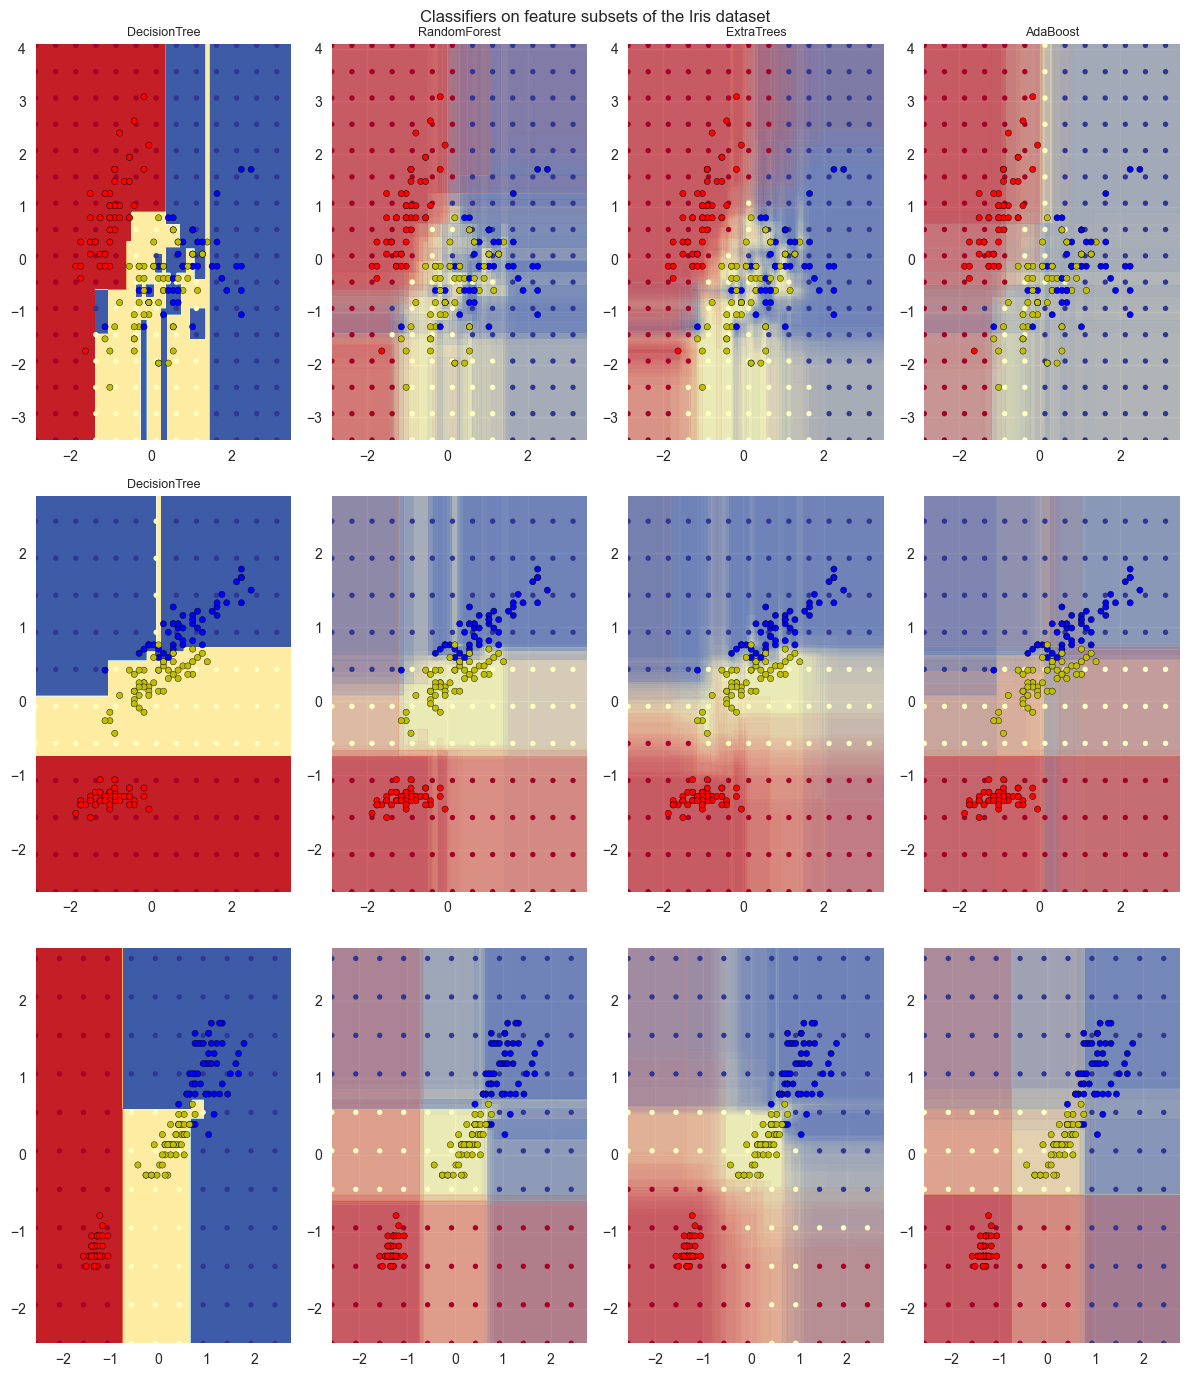

In [3]:
# 导入操作系统库
import os
# 更改工作目录
os.chdir(r"D:\softwares\applied statistics\pythoncodelearning\chap6\sourcecode")
# 导入基础计算库
import numpy as np
# 导入绘图库
import matplotlib.pyplot as plt
# 导入颜色库
from matplotlib.colors import ListedColormap
# 导入数据集工具
from sklearn.datasets import load_iris
# 导入集成模型
from sklearn.ensemble import (
    RandomForestClassifier, # 随机森林
    ExtraTreesClassifier, # 额外树
    AdaBoostClassifier, # adaboost模型
)
# 导入决策树分类器
from sklearn.tree import DecisionTreeClassifier
# 导入绘图库中的字体管理包
from matplotlib import font_manager
# 实现中文字符正常显示
font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\SimKai.ttf")
# 使用seaborn风格绘图
plt.style.use("seaborn-v0_8")
# 类别
n_classes = 3
# 估计器数量
n_estimators = 30
# 选择颜色
cmap = plt.cm.RdYlBu
# step width for decision surface contours
plot_step = 0.02
# step widths for coarse classifier guesses
plot_step_coarser = 0.5
# fix the seed on each iteration
RANDOM_SEED = 13
# 加载数据
iris = load_iris()
# 图形编号
plot_idx = 0
# 构建模型
models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators),
    ExtraTreesClassifier(n_estimators=n_estimators),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators),
]
# 开始绘图
fig, axs = plt.subplots(3, 4, figsize=(12, 14), tight_layout=True)
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # 只提取两个维度的变量
        X = iris.data[:, pair]
        y = iris.target
        # 构造训练集
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        # 标准化
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std
        # 模型拟合
        model.fit(X, y)
        # 模型在训练集上的预测准确率
        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(model_details + " with features", pair, "has a score of", scores)

        ax = axs.flatten()[plot_idx]
        if plot_idx <= len(models):
            # Add a title at the top of each column
            ax.set_title(model_title, fontsize=9)
        # 绘制等高线，决策边界
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )
        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            # 模型预测
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            # 将Z重塑
            Z = Z.reshape(xx.shape)
            # 等高线
            cs = ax.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = ax.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = model.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = ax.scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )
        # Plot the training points, these are clustered together and have a
        # black outline
        ax.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.show()
fig.savefig("../codeimage/code2.pdf")
